In [125]:
import numpy as np
import matplotlib.pyplot as plt
import uproot
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [126]:
N = 20000

file = uproot.open('data/merged_20000_evts.root')
tree = file['ttree']


pid = tree['truthpar_id'].array(library='np', entry_stop=N)
px = tree['truthpar_px'].array(library='np', entry_stop=N)
py = tree['truthpar_py'].array(library='np', entry_stop=N)
pz = tree['truthpar_pz'].array(library='np', entry_stop=N)

pid = np.concatenate(pid,axis=0)
pid = (pid == 22).astype(int)

px = np.concatenate(px,axis=0)
py = np.concatenate(py,axis=0)
pz = np.concatenate(pz,axis=0)

In [127]:
pt = []
eta = []
phi = []

for i in range(N):
    pt.append(np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i]))
    p = np.sqrt(px[i]*px[i]+py[i]*py[i]+pz[i]*pz[i])
    eta.append(0.5 * np.log((p + pz[i]) / (p - pz[i])))
    phi.append(np.arctan2(py[i],px[i]))
    
pt = np.array(pt)
eta = np.array(eta)
phi = np.array(phi)

In [128]:
e_tow = tree['emcalen'].array(library='np', entry_stop=N)
eta_tow = tree['emcalet'].array(library='np', entry_stop=N)
phi_tow = tree['emcalph'].array(library='np', entry_stop=N)

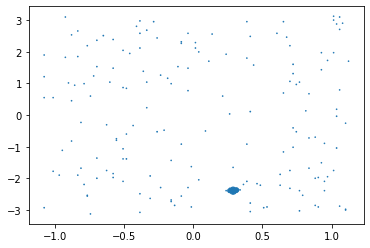

In [129]:
event=10025
plt.scatter(eta_tow[event],phi_tow[event],s=10*e_tow[event]);

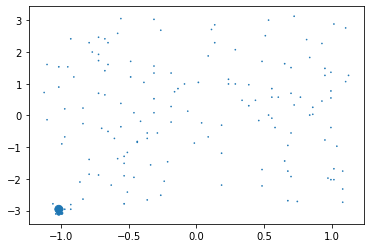

In [130]:
plt.scatter(eta_tow[1],phi_tow[1],s=10*e_tow[1]);

In [131]:
eta_values = set()

for et in eta_tow:
    eta_values = eta_values.union(set(et))
    
eta_values = list(eta_values)
eta_values.sort()

eta_dict = dict()

for i,et in enumerate(eta_values):
    eta_dict[et] = i

In [132]:
phi_values = set()

for ph in phi_tow:
    phi_values = phi_values.union(set(ph))
    
phi_values = list(phi_values)
phi_values.sort()

phi_dict = dict()

for i,ph in enumerate(phi_values):
    phi_dict[ph] = i

In [133]:
ieta_tow = []
iphi_tow = [] 

for et,ph in zip(eta_tow,phi_tow):
    ieta_event = []
    iphi_event = []
    for e,p in zip(et,ph):
        ieta_event.append(eta_dict[e])
        iphi_event.append(phi_dict[p])
    ieta_tow.append(np.array(ieta_event))
    iphi_tow.append(np.array(iphi_event))
    
ieta_tow = np.array(ieta_tow,dtype=object)
iphi_tow = np.array(iphi_tow,dtype=object)

In [134]:
seed_e = np.zeros(N)
seed_eta = np.zeros(N)
seed_ieta = np.zeros(N,dtype=int)
seed_phi = np.zeros(N)
seed_iphi = np.zeros(N,dtype=int)

nmax_e = np.zeros(N)
nmax_eta = np.zeros(N)
nmax_ieta = np.zeros(N,dtype=int)
nmax_phi = np.zeros(N)
nmax_iphi = np.zeros(N,dtype=int)

eta_zero = []
phi_zero = []

i = 0
for e,et,ph in zip(e_tow,eta_tow,phi_tow):
    e_copy = e.copy()
    e_copy.sort()
    seed_e[i] = e_copy[-1]
    seed_index = list(e).index(seed_e[i])
    seed_eta[i] = et[seed_index]
    seed_ieta[i] = eta_dict[seed_eta[i]]
    seed_phi[i] = ph[seed_index]
    seed_iphi[i] = phi_dict[seed_phi[i]]
    
    nmax_e[i] = e_copy[-2]
    nmax_index = list(e).index(nmax_e[i])
    nmax_eta[i] = et[nmax_index]
    nmax_ieta[i] = eta_dict[nmax_eta[i]]
    nmax_phi[i] = ph[nmax_index]
    nmax_iphi[i] = phi_dict[nmax_phi[i]]
    
    
    if seed_e[i] < 0.1:
        eta_zero.append(eta[i])
        phi_zero.append(phi[i])
    
    i += 1

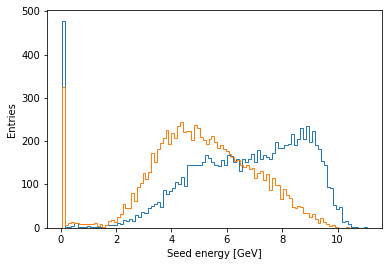

In [94]:
plt.hist(seed_e[pid == 1], bins=100, histtype='step')
plt.hist(seed_e[pid == 0], bins=100, histtype='step')
plt.xlabel("Seed energy [GeV]")
plt.ylabel("Entries");

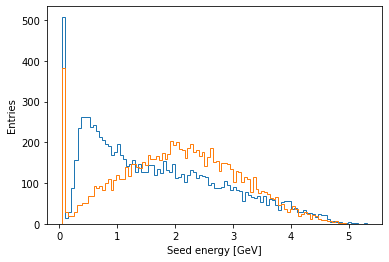

In [95]:
plt.hist(nmax_e[pid == 1], bins=100, histtype='step')
plt.hist(nmax_e[pid == 0], bins=100, histtype='step')
plt.xlabel("Seed energy [GeV]")
plt.ylabel("Entries");

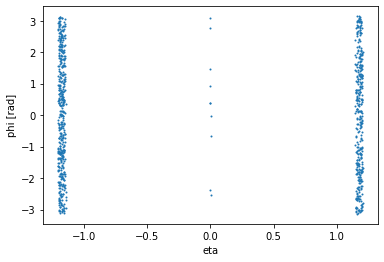

In [13]:
plt.scatter(eta_zero,phi_zero,s=1)
plt.xlabel("eta")
plt.ylabel("phi [rad]");

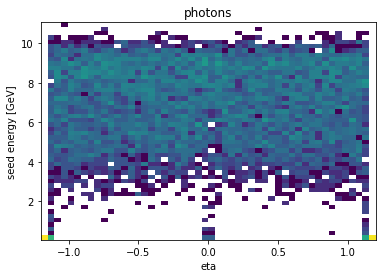

In [14]:
from   matplotlib import colors
plt.hist2d(eta[pid == 1],seed_e[pid == 1],bins=(50,50),norm=colors.LogNorm(1.0))
plt.title("photons")
plt.xlabel("eta")
plt.ylabel("seed energy [GeV]");

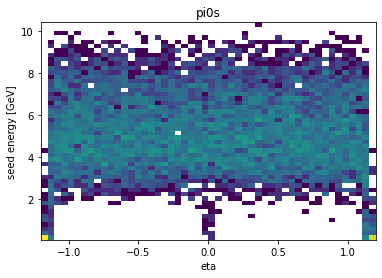

In [15]:
from   matplotlib import colors
plt.hist2d(eta[pid == 0],seed_e[pid == 0],bins=(50,50),norm=colors.LogNorm(1.0))
plt.title("pi0s")
plt.xlabel("eta")
plt.ylabel("seed energy [GeV]");

In [16]:
clusters = np.zeros((N,25),dtype=float)
clusters7x7 = np.zeros((N,49),dtype=float)
clusters9x9 = np.zeros((N,81),dtype=float)
clusters19x19 = np.zeros((N,19*19),dtype=float)

for i in range(N):
    if seed_e[i] < 0.1 or seed_ieta[i] < 2 or seed_ieta[i] > 93:
        continue
    
    for iet in range(0,5):
        for iph in range(0,5):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-2) & (iphi_tow[i] == (iph+seed_iphi[i]-2) % 256))[0]
            if len(index) == 1:
                clusters[i][iet + iph*5] = e_tow[i][index]/seed_e[i]
            else:
                clusters[i][iet + iph*5] = 0            
     
    for iet in range(0,7):
        for iph in range(0,7):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-3) & (iphi_tow[i] == (iph+seed_iphi[i]-3) % 256))[0]
            if len(index) == 1:
                clusters7x7[i][iet + iph*7] = e_tow[i][index]/seed_e[i]
            else:
                clusters7x7[i][iet + iph*7] = 0
                
    for iet in range(0,9):
        for iph in range(0,9):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-4) & (iphi_tow[i] == (iph+seed_iphi[i]-4) % 256))[0]
            if len(index) == 1:
                clusters9x9[i][iet + iph*9] = e_tow[i][index]/seed_e[i]
            else:
                clusters9x9[i][iet + iph*9] = 0
                
    for iet in range(0,19):
        for iph in range(0,19):
            index = np.where((ieta_tow[i] == iet+seed_ieta[i]-9) & (iphi_tow[i] == (iph+seed_iphi[i]-9) % 256))[0]
            if len(index) == 1:
                clusters19x19[i][iet + iph*19] = e_tow[i][index]/seed_e[i]
            else:
                clusters19x19[i][iet + iph*19] = 0   

In [17]:
condition = (seed_e > 0.1) & (seed_ieta > 2) & (seed_ieta < 94)
pid_cleaned = pid[np.where(condition)[0]]
clusters_cleaned = clusters[np.where(condition)[0]]
clusters9x9ada_cleaned = clusters9x9[np.where(condition)[0]]

condition = (seed_e > 0.1) & (seed_ieta > 8) & (seed_ieta < 88)
pidNN_cleaned = pid[np.where(condition)[0]]
clusters5x5_cleaned = clusters[np.where(condition)[0]]
clusters7x7_cleaned = clusters7x7[np.where(condition)[0]]
clusters9x9_cleaned = clusters9x9[np.where(condition)[0]]
clusters19x19_cleaned = clusters19x19[np.where(condition)[0]]

In [92]:
clusters[0]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01282432, 0.00788321, 0.        , 0.        ,
       0.01165847, 0.16176128, 1.        , 0.01985402, 0.        ,
       0.        , 0.06965937, 0.1220438 , 0.00671533, 0.        ,
       0.0061207 , 0.00728654, 0.00613139, 0.00642336, 0.        ])

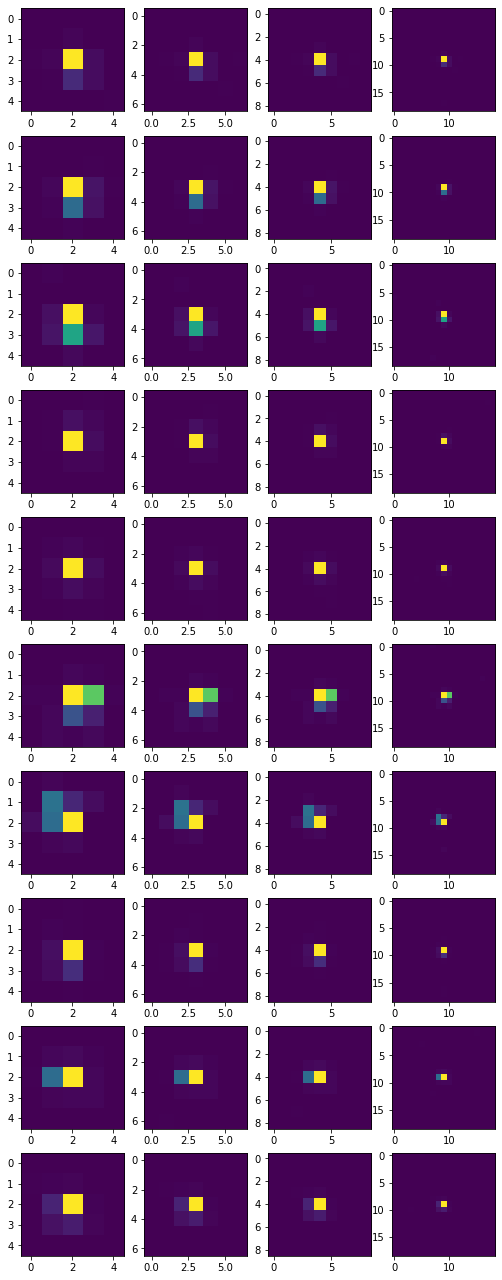

In [93]:
plt.rcParams['figure.figsize'] = [8.5, 23]

for i in range(10):
    plt.subplot(10,4,4*i+1)
    plt.imshow(clusters[i+10].reshape(5,5));
    plt.subplot(10,4,4*i+2)
    plt.imshow(clusters7x7[i+10].reshape(7,7));
    plt.subplot(10,4,4*i+3)
    plt.imshow(clusters9x9[i+10].reshape(9,9));
    plt.subplot(10,4,4*i+4)
    plt.imshow(clusters19x19[i+10].reshape(19,19));

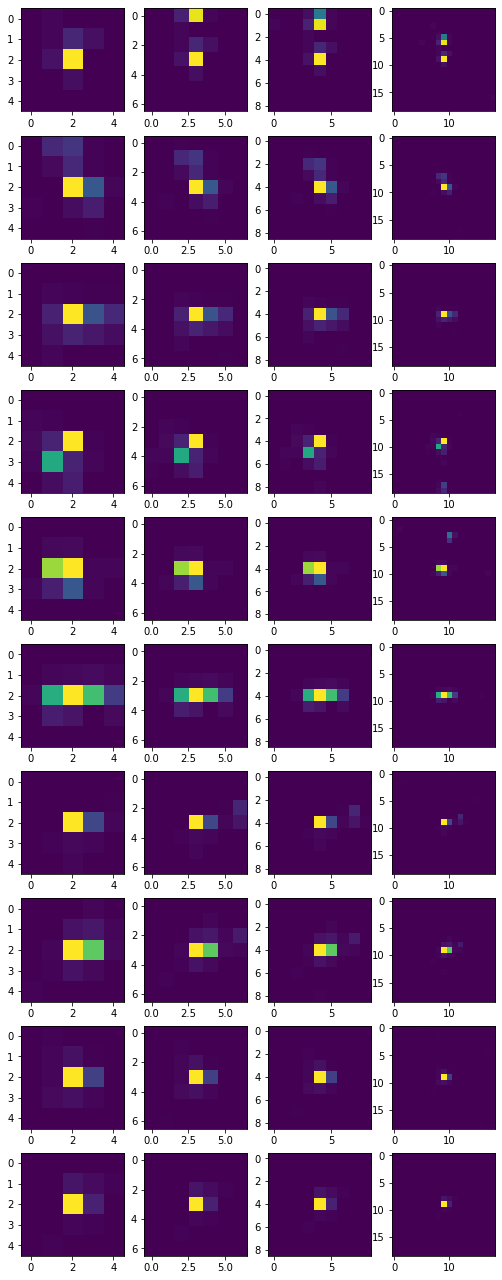

In [94]:
for i in range(10):
    plt.subplot(10,4,4*i+1)
    plt.imshow(clusters[10100+i].reshape(5,5));
    plt.subplot(10,4,4*i+2)
    plt.imshow(clusters7x7[10100+i].reshape(7,7));
    plt.subplot(10,4,4*i+3)
    plt.imshow(clusters9x9[10100+i].reshape(9,9));
    plt.subplot(10,4,4*i+4)
    plt.imshow(clusters19x19[10100+i].reshape(19,19));

In [95]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]

## 2. Simple linear model: logistic regression

### 2.1. Logistic regression using cluster images

In [96]:
X_train, X_test, y_train, y_test = train_test_split(clusters_cleaned, pid_cleaned, test_size=0.33, random_state=42)

clf1 = LogisticRegression(max_iter=1000)

clf1.fit(X_train,y_train)
clf1.score(X_test,y_test)

0.767962308598351

pi0 rejection rate: 0.6635545181727243
photon rejection rate: 0.485054347826087


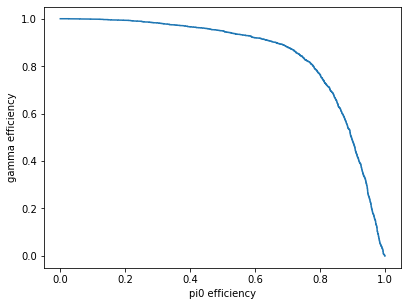

In [97]:
y_score = clf1.fit(X_train, y_train).decision_function(X_test)

fpr_lr, tpr_lr, thresholds = metrics.roc_curve(y_test, y_score)

plt.plot(1-fpr_lr,tpr_lr)
plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency");

print("pi0 rejection rate:",np.interp(0.9,tpr_lr,1-fpr_lr))
print("photon rejection rate:",np.interp(0.1,fpr_lr,tpr_lr))

### 2.2. $\eta_{\text{seed}}$ dependence

0.0 < |eta| < 0.3: sample size: 4967 accuracy: 0.7414634146341463
0.3 < |eta| < 0.6: sample size: 4815 accuracy: 0.7665198237885462
0.6 < |eta| < 0.9: sample size: 5011 accuracy: 0.7926239419588875
0.9 < |eta| < 1.2: sample size: 2990 accuracy: 0.7689969604863222


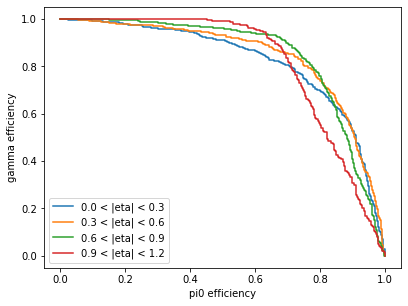

In [98]:
# Studying in 4 eta bins:
# 1.        |eta| < 0.3
# 2. 0.3 < |eta| < 0.6
# 3. 0.6 < |eta| < 0.9
# 4. 0.9 < |eta|

eta_bins = [0.0,0.3,0.6,0.9,1.2]

for i in range(1,len(eta_bins)):
    condition = (seed_e > 0.1) & (seed_ieta > 2) & (seed_ieta < 93) & (eta_bins[i-1] < np.abs(seed_eta)) & (eta_bins[i] > np.abs(seed_eta))
    
    
    pid_slice = pid[np.where(condition)[0]]
    clusters_slice = clusters[np.where(condition)[0]]
    
    X_train, X_test, y_train, y_test = train_test_split(clusters_slice, pid_slice, test_size=0.33, random_state=42)
    
    clf1.fit(X_train,y_train)
    print("{} < |eta| < {}:".format(eta_bins[i-1],eta_bins[i]),"sample size:", sum(condition),"accuracy:", clf1.score(X_test,y_test))
    
    y_score = clf1.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)

    plt.plot(1-fpr,tpr,label="{} < |eta| < {}".format(eta_bins[i-1],eta_bins[i]))
    plt.xlabel("pi0 efficiency")
    plt.ylabel("gamma efficiency")
    plt.legend()

## 3. Non-linear classifier: decision tree

In [99]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf2 = DecisionTreeClassifier(max_depth=10)
clf2.fit(X_train,y_train)
clf2.score(X_test,y_test)

0.7527862208713273

In [100]:
from sklearn.model_selection import GridSearchCV

parameters = {'criterion':('gini', 'entropy'), 'splitter':('best','random'), 'max_depth': range(3,25)}
clf3 = GridSearchCV(DecisionTreeClassifier(), parameters)
clf3.fit(X_train,y_train)
clf3.score(X_test,y_test)

0.7639311043566362

pi0 rejection rate: 0.632
photon rejection rate: 0.16763113683031547


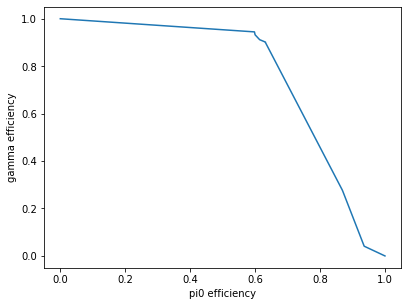

In [101]:
fpr_dt, tpr_dt, thresholds = metrics.roc_curve(y_test, clf3.predict_proba(X_test)[:,1])

plt.plot(1-fpr_dt,tpr_dt)
plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency");

print("pi0 rejection rate:",np.interp(0.9,tpr_dt,1-fpr_dt))
print("photon rejection rate:",np.interp(0.1,fpr_dt,tpr_dt))

## 4. Ensemble method: AdaBoost (boosted decision trees)

In [102]:
from sklearn.ensemble import AdaBoostClassifier

clf4 = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),n_estimators=300,random_state=0)
clf4.fit(X_train,y_train)
clf4.score(X_test,y_test)

0.7689969604863222

In [103]:
parameters = {'base_estimator':(DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)),
              'n_estimators':range(50,500,50)}
clf5 = GridSearchCV(AdaBoostClassifier(), parameters)
clf5.fit(X_train,y_train)
clf5.score(X_test,y_test)

0.7760891590678825

pi0 rejection rate: 0.6599999999999999
photon rejection rate: 0.2915811088295688


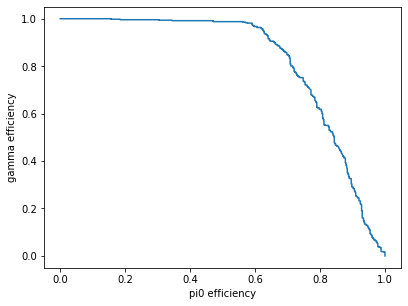

In [104]:
fpr_bdt, tpr_bdt, thresholds = metrics.roc_curve(y_test, clf5.predict_proba(X_test)[:,1])

plt.plot(1-fpr_bdt,tpr_bdt)
plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency");

print("pi0 rejection rate:",np.interp(0.9,tpr_bdt,1-fpr_bdt))
print("photon rejection rate:",np.interp(0.1,fpr_bdt,tpr_bdt))

## 5. Engineering new features

In [105]:
# auxiliary variables for calculation of sigma_ieta_ieta

cluster_ieta = np.array(
        [
            [0,1,2,3,4],
            [0,1,2,3,4],
            [0,1,2,3,4],
            [0,1,2,3,4],
            [0,1,2,3,4]
        ]
)

cluster_iphi = np.transpose(cluster_ieta)

d_ieta = cluster_ieta - 2
d_iphi = cluster_iphi - 2

d2_ieta = d_ieta**2
d2_iphi = d_iphi**2


In [106]:
R9 = []
swiss_cross = []
sigma_ieta_ieta = []
sigma_iphi_iphi = []
s9nmax = []
s25nmax = []

for cluster in clusters_cleaned:
    cluster5x5 = cluster.reshape(5,5)
    E5x5 = np.sum(cluster,axis=None)
    core = cluster5x5[1:4,1:4]
    E3x3 = np.sum(core,axis=None)
    R9.append(E3x3/E5x5)
    
    core_seedless = core.copy()
    core_seedless[1,1] = 0
    s9nmax.append(np.max(core_seedless,axis=None))
    
    cluster_seedless = cluster5x5.copy()
    cluster_seedless[2,2] = 0
    s25nmax.append(np.max(cluster_seedless,axis=None))
    
    E4 = (core[0,1]+core[1,0]+core[1,2]+core[2,1])
    if E4 > 0:
        swiss_cross.append(E4/core[1,1])
    else:
        swiss_cross.append(0)
    
    w = 4.7 + np.log(cluster5x5/E5x5,out=np.zeros_like(cluster5x5),where=(cluster5x5 != 0))
    w[w < 0] = 0
    
    sigma_ieta_ieta.append(np.sqrt(np.sum(w * d2_ieta,axis=None) / np.sum(w,axis=None)))
    sigma_iphi_iphi.append(np.sqrt(np.sum(w * d2_iphi,axis=None) / np.sum(w,axis=None)))
    
R9 = np.array(R9).reshape(-1,1)
swiss_cross = np.array(swiss_cross).reshape(-1,1)
sigma_ieta_ieta = np.array(sigma_ieta_ieta).reshape(-1,1)
sigma_iphi_iphi = np.array(sigma_iphi_iphi).reshape(-1,1)
s9nmax = np.array(s9nmax).reshape(-1,1)
s25nmax = np.array(s25nmax).reshape(-1,1)

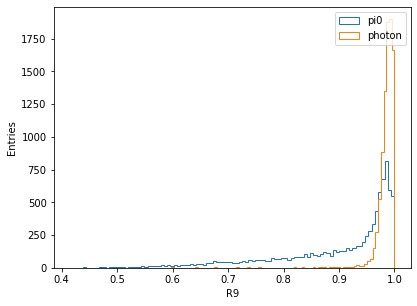

In [107]:
plt.hist(R9[pid_cleaned == 0],bins=100,histtype='step',label='pi0');
plt.hist(R9[pid_cleaned == 1],bins=100,histtype='step',label='photon');
plt.xlabel("R9")
plt.ylabel("Entries")
plt.legend();

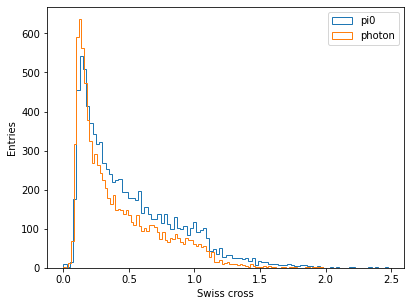

In [108]:
plt.hist(swiss_cross[pid_cleaned == 0],bins=100,histtype='step',label='pi0');
plt.hist(swiss_cross[pid_cleaned == 1],bins=100,histtype='step',label='photon');
plt.xlabel("Swiss cross")
plt.ylabel("Entries")
plt.legend();

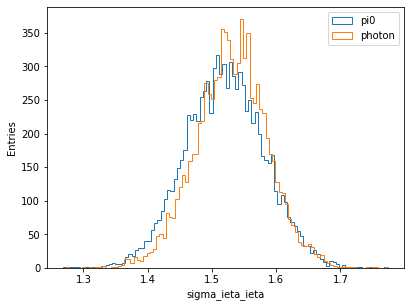

In [109]:
plt.hist(sigma_ieta_ieta[pid_cleaned == 0],bins=100,histtype='step',label='pi0');
plt.hist(sigma_ieta_ieta[pid_cleaned == 1],bins=100,histtype='step',label='photon');
plt.xlabel("sigma_ieta_ieta")
plt.ylabel("Entries")
plt.legend();

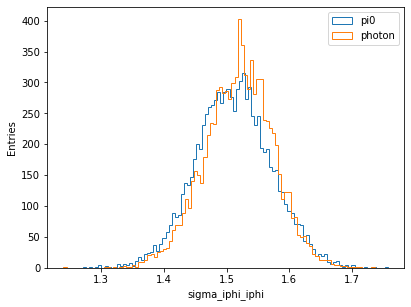

In [110]:
plt.hist(sigma_iphi_iphi[pid_cleaned == 0],bins=100,histtype='step',label='pi0');
plt.hist(sigma_iphi_iphi[pid_cleaned == 1],bins=100,histtype='step',label='photon');
plt.xlabel("sigma_iphi_iphi")
plt.ylabel("Entries")
plt.legend();

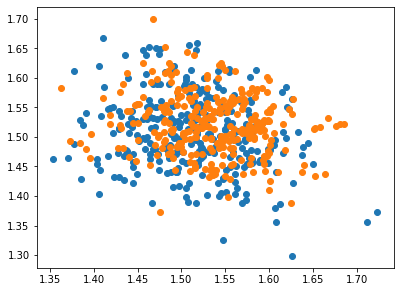

In [111]:
plt.scatter(sigma_ieta_ieta[10000:10300],sigma_iphi_iphi[10000:10300])
plt.scatter(sigma_ieta_ieta[0:300],sigma_iphi_iphi[0:300]);

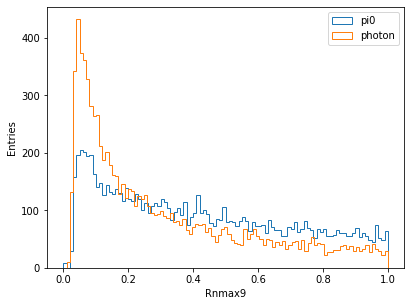

In [112]:
plt.hist(s9nmax[pid_cleaned == 0],bins=100,histtype='step',label='pi0');
plt.hist(s9nmax[pid_cleaned == 1],bins=100,histtype='step',label='photon');
plt.xlabel("Rnmax9")
plt.ylabel("Entries")
plt.legend();

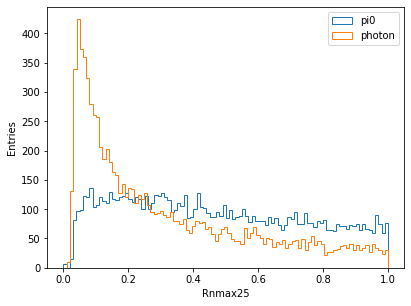

In [113]:
plt.hist(s25nmax[pid_cleaned == 0],bins=100,histtype='step',label='pi0');
plt.hist(s25nmax[pid_cleaned == 1],bins=100,histtype='step',label='photon');
plt.xlabel("Rnmax25")
plt.ylabel("Entries")
plt.legend();

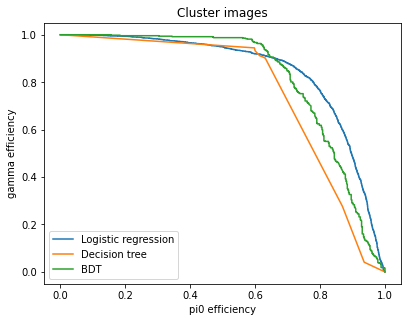

In [114]:
X_train, X_test, y_train, y_test = train_test_split(eng_features_w_clusters, pid_cleaned, test_size=0.33, random_state=42)

# Logistic regression


plt.plot(1-fpr_lr,tpr_lr,label="Logistic regression")
plt.plot(1-fpr_dt,tpr_dt,label="Decision tree")
plt.plot(1-fpr_bdt,tpr_bdt,label="BDT")

plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency");
plt.title("Cluster images")
plt.legend()

In [115]:
eng_features = np.concatenate((R9,swiss_cross,sigma_ieta_ieta,sigma_iphi_iphi,s9nmax,s25nmax),axis=1)
eng_features_w_clusters = np.concatenate((clusters_cleaned,R9,swiss_cross,sigma_ieta_ieta,sigma_iphi_iphi,s9nmax,s25nmax),axis=1)

Logistic regression: 0.7610634359750967
pi0 rejection rate: 0.618539513171057
photon rejection rate: 0.4548233695652174
Decision tree: 0.7942116776039038
pi0 rejection rate: 0.6843141687530495
photon rejection rate: 0.47744712901701325
AdaBoost: 0.8017836109708901
pi0 rejection rate: 0.7075691897299099
photon rejection rate: 0.46728940217391307


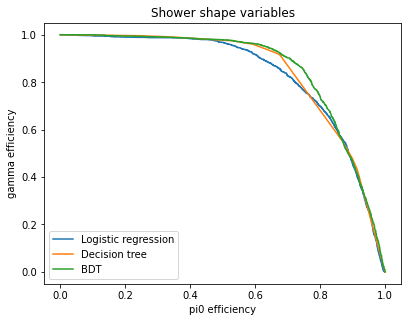

In [116]:
X_train, X_test, y_train, y_test = train_test_split(eng_features, pid_cleaned, test_size=0.33, random_state=42)

# Logistic regression
clf1.fit(X_train,y_train)
print("Logistic regression:", clf1.score(X_test,y_test))

fpr_lr_ss, tpr_lr_ss, thresholds = metrics.roc_curve(y_test, clf1.predict_proba(X_test)[:,1])

plt.plot(1-fpr_lr_ss,tpr_lr_ss,label="Logistic regression")

print("pi0 rejection rate:",np.interp(0.9,tpr_lr_ss,1-fpr_lr_ss))
print("photon rejection rate:",np.interp(0.1,fpr_lr_ss,tpr_lr_ss))

# Decision tree
clf3.fit(X_train,y_train)
print("Decision tree:",clf3.score(X_test,y_test))

fpr_dt_ss, tpr_dt_ss, thresholds = metrics.roc_curve(y_test, clf3.predict_proba(X_test)[:,1])

plt.plot(1-fpr_dt_ss,tpr_dt_ss,label="Decision tree")

print("pi0 rejection rate:",np.interp(0.9,tpr_dt_ss,1-fpr_dt_ss))
print("photon rejection rate:",np.interp(0.1,fpr_dt_ss,tpr_dt_ss))

#AdaBoost
clf5.fit(X_train,y_train)
print("AdaBoost:",clf5.score(X_test,y_test))

fpr_bdt_ss, tpr_bdt_ss, thresholds = metrics.roc_curve(y_test, clf5.predict_proba(X_test)[:,1])

plt.plot(1-fpr_bdt_ss,tpr_bdt_ss,label="BDT")

plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency");
plt.title("Shower shape variables")
plt.legend()

print("pi0 rejection rate:",np.interp(0.9,tpr_bdt_ss,1-fpr_bdt_ss))
print("photon rejection rate:",np.interp(0.1,fpr_bdt_ss,tpr_bdt_ss))


Logistic regression: 0.7974087161366313
pi0 rejection rate: 0.7129043014338112
photon rejection rate: 0.48403532608695654
Decision tree: 0.8224802288406529
pi0 rejection rate: 0.747014084059766
photon rejection rate: 0.3333139582552474
AdaBoost: 0.839979808177688
pi0 rejection rate: 0.782594198066022
photon rejection rate: 0.5414402173913043


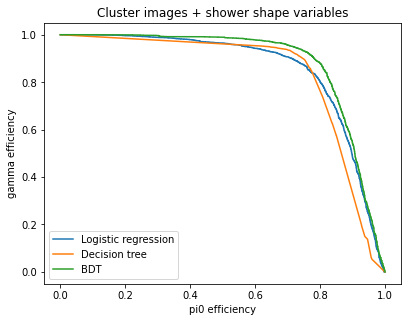

In [117]:
X_train, X_test, y_train, y_test = train_test_split(eng_features_w_clusters, pid_cleaned, test_size=0.33, random_state=42)

# Logistic regression
clf1.fit(X_train,y_train)
print("Logistic regression:", clf1.score(X_test,y_test))

fpr_lr_ss_ce, tpr_lr_ss_ce, thresholds = metrics.roc_curve(y_test, clf1.predict_proba(X_test)[:,1])

plt.plot(1-fpr_lr_ss_ce,tpr_lr_ss_ce,label="Logistic regression")

print("pi0 rejection rate:",np.interp(0.9,tpr_lr_ss_ce,1-fpr_lr_ss_ce))
print("photon rejection rate:",np.interp(0.1,fpr_lr_ss_ce,tpr_lr_ss_ce))

# Decision tree
clf3.fit(X_train,y_train)
print("Decision tree:",clf3.score(X_test,y_test))

fpr_dt_ss_ce, tpr_dt_ss_ce, thresholds = metrics.roc_curve(y_test, clf3.predict_proba(X_test)[:,1])

plt.plot(1-fpr_dt_ss_ce,tpr_dt_ss_ce,label="Decision tree")

print("pi0 rejection rate:",np.interp(0.9,tpr_dt_ss_ce,1-fpr_dt_ss_ce))
print("photon rejection rate:",np.interp(0.1,fpr_dt_ss_ce,tpr_dt_ss_ce))

#AdaBoost
clf5.fit(X_train,y_train)
print("AdaBoost:",clf5.score(X_test,y_test))

fpr_bdt_ss_ce, tpr_bdt_ss_ce, thresholds = metrics.roc_curve(y_test, clf5.predict_proba(X_test)[:,1])

plt.plot(1-fpr_bdt_ss_ce,tpr_bdt_ss_ce,label="BDT")

plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency");
plt.title("Cluster images + shower shape variables")
plt.legend()

print("pi0 rejection rate:",np.interp(0.9,tpr_bdt_ss_ce,1-fpr_bdt_ss_ce))
print("photon rejection rate:",np.interp(0.1,fpr_bdt_ss_ce,tpr_bdt_ss_ce))


In [118]:
y_pred = clf5.predict(X_test)

misclassified = X_test[y_pred != y_test]
y_pred_mis = y_pred[y_pred != y_test]
y_test_mis = y_test[y_pred != y_test]

i = 0

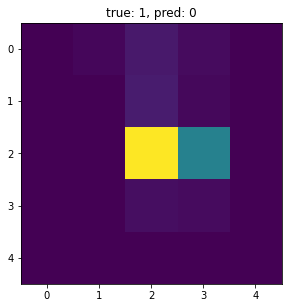

In [119]:
plt.imshow(misclassified[i][0:25].reshape(5,5))
plt.title("true: {}, pred: {}".format(y_test_mis[i],y_pred_mis[i]))
i += 1

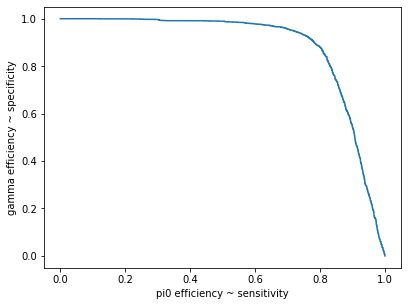

In [120]:
y_score = clf5.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score)

plt.plot(1-fpr,tpr)
plt.xlabel("pi0 efficiency ~ sensitivity")
plt.ylabel("gamma efficiency ~ specificity");

In [121]:
clf5.best_estimator_.feature_importances_

array([0.00588706, 0.02131289, 0.04351128, 0.03204984, 0.00721651,
       0.02642321, 0.05894917, 0.03984391, 0.02995545, 0.02477906,
       0.03695772, 0.05087299, 0.        , 0.04526698, 0.01436365,
       0.01542352, 0.03940025, 0.06023596, 0.04358003, 0.01361794,
       0.01381014, 0.03102602, 0.03598903, 0.01320977, 0.01058616,
       0.09087717, 0.05162393, 0.03637319, 0.05848815, 0.02975707,
       0.01861197])

Text(0.5, 1.0, 'Feature importances')

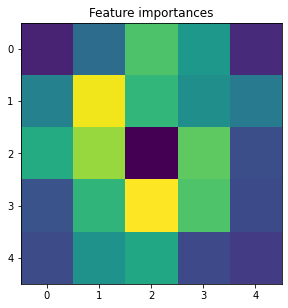

In [122]:
plt.imshow(clf5.best_estimator_.feature_importances_[0:25].reshape(5,5))
plt.title("Feature importances")

## 6. Deep learning: multilayer perceptron

In [123]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(clusters5x5_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

clf6 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=1, max_iter=10000, learning_rate='adaptive')
clf6.fit(X_train,y_train)
print(clf6a.score(X_test,y_test))

fpr5x5, tpr5x5, thresholds = metrics.roc_curve(y_test, clf6a.predict_proba(X_test)[:,1])

NameError: name 'clf6a' is not defined

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clusters7x7_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

clf6 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=1, max_iter=15000, learning_rate='adaptive')
clf6.fit(X_train,y_train)
print(clf6.score(X_test,y_test))

fpr7x7, tpr7x7, thresholds = metrics.roc_curve(y_test, clf6.predict_proba(X_test)[:,1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clusters9x9_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

clf6 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=1, max_iter=10000, learning_rate='adaptive')
clf6.fit(X_train,y_train)
print(clf6.score(X_test,y_test))

fpr9x9, tpr9x9, thresholds = metrics.roc_curve(y_test, clf6.predict_proba(X_test)[:,1])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(clusters19x19_cleaned, pidNN_cleaned, test_size=0.33, random_state=42)

clf6 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(16, 16), random_state=1, max_iter=20000, learning_rate='adaptive')
clf6.fit(X_train,y_train)
print(clf6.score(X_test,y_test))

fpr19x19, tpr19x19, thresholds = metrics.roc_curve(y_test, clf6.predict_proba(X_test)[:,1])

## 7. Revisiting adaBoost with larger cluster size

In [ ]:
eng_features = np.concatenate((clusters9x9ada_cleaned,R9,swiss_cross,sigma_ieta_ieta,sigma_iphi_iphi,s9nmax,s25nmax),axis=1)

X_train, X_test, y_train, y_test = train_test_split(eng_features, pid_cleaned, test_size=0.33, random_state=42)

clf5.fit(X_train,y_train)
print(clf5.score(X_test,y_test))

In [ ]:
fpr_dt_ss_ce, tpr_dt_ss_ce, thresholds = metrics.roc_curve(y_test, clf5.predict_proba(X_test)[:,1])

plt.plot(1-fpr_dt_ss_ce,tpr_dt_ss_ce,label="BDT")
plt.plot(1-fpr9x9,tpr9x9,label="Neural network")

print("pi0 rejection rate:",np.interp(0.9,tpr_dt_ss_ce,1-fpr_dt_ss_ce))
print("photon rejection rate:",np.interp(0.1,fpr_dt_ss_ce,tpr_dt_ss_ce))

plt.xlabel("pi0 efficiency")
plt.ylabel("gamma efficiency")
plt.title("9 x 9 cluster image")
plt.legend();

## 8. $\eta$ dependence with neural networks

In [ ]:
# Studying in 4 eta bins:
# 1.        |eta| < 0.3
# 2. 0.3 < |eta| < 0.6
# 3. 0.6 < |eta| < 0.9
# 4. 0.9 < |eta|

eta_bins = [0.0,0.3,0.6,0.9,1.2]

accuracy = []
pi0_rej = []
pho_rej = []

for i in range(1,len(eta_bins)):
    condition = (seed_e > 0.1) & (seed_ieta > 4) & (seed_ieta < 92) & (eta_bins[i-1] < np.abs(seed_eta)) & (eta_bins[i] > np.abs(seed_eta))
    
    pid_slice = pid[np.where(condition)[0]]
    clusters_slice = clusters9x9[np.where(condition)[0]]
    
    X_train, X_test, y_train, y_test = train_test_split(clusters_slice, pid_slice, test_size=0.33, random_state=42)
    
    clf6.fit(X_train,y_train)

    fpr, tpr, thresholds = metrics.roc_curve(y_test, clf6.predict_proba(X_test)[:,1])

    plt.plot(1-fpr,tpr,label="{} < |eta| < {}".format(eta_bins[i-1],eta_bins[i]))
    plt.xlabel("pi0 efficiency")
    plt.ylabel("gamma efficiency")
    plt.legend()
    
    accuracy.append(clf6.score(X_test,y_test))
    pi0_rej.append(np.interp(0.9,tpr,1-fpr))
    pho_rej.append(np.interp(0.1,fpr,tpr))

In [ ]:
eta_bin_center = [0.15,0.45,0.75,1.05]

plt.plot(eta_bin_center,accuracy,label="Accuracy")
plt.plot(eta_bin_center,pi0_rej,label="Pion rejection")
plt.plot(eta_bin_center,pho_rej,label="Photon rejection")

plt.xlabel("eta")
plt.ylabel("score")
plt.legend();


## 9. Considering only merging $\pi^0$s

Merging $\pi^0$s in this sample are defined as $\pi^0$ events, in which the next-to-leading tower deposit (if sufficiently large) is adjacent to the seed.

(array([   6.,    5.,    6.,    9.,   22.,   39.,   50.,   57.,   26.,
        2897., 4338., 1815.,   25.,   65.,   77.,   45.,   14.,   16.,
          13.,    7.,    0.]),
 array([-10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,  -2.5,
         -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,
          7.5,   8.5,   9.5,  10.5]),
 <BarContainer object of 21 artists>)

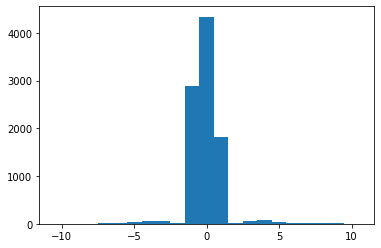

In [135]:
d_iphi = (seed_iphi[pid == 1]-nmax_iphi[pid == 1])
d_iphi[d_iphi >= 128] = 256 - d_iphi[d_iphi >= 128]
d_iphi[d_iphi < -128] = 256 + d_iphi[d_iphi < -128]
plt.hist(d_iphi,bins=np.arange(-10.5, 10.5+1, 1))

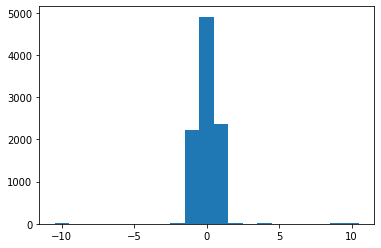

In [137]:
d_ieta = (seed_ieta[pid == 1]-nmax_ieta[pid == 1])
plt.hist(d_ieta,bins=np.arange(-10.5, 10.5+1, 1));

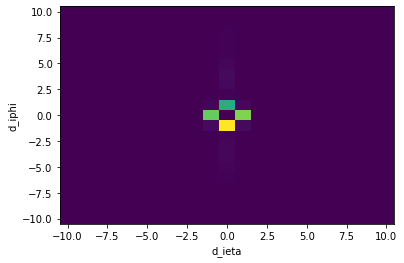

In [139]:
plt.hist2d(d_ieta,d_iphi,bins=np.arange(-10.5, 10.5+1, 1))
plt.xlabel("d_ieta")
plt.ylabel("d_iphi");